In [72]:
import pinocchio as pin
from pinocchio.utils import *
import numpy as np

import matplotlib.pyplot as plt

import time
from panda3d_viewer import ViewerClosedError
from pinocchio.visualize.panda3d_visualizer import Panda3dVisualizer

robot = pin.RobotWrapper()
robot.initFromURDF("Exo/description_v1.urdf")

print('model name: ' + robot.model.name)
 
# Sample a random configuration
q         = zero(robot.model.nv) ;
qd        = zero(robot.model.nv) ;
qdd       = zero(robot.model.nv) ;

q_des     = zero(robot.model.nv) ;
qd_des    = zero(robot.model.nv) ;
qdd_des   = zero(robot.model.nv) ;

tau       = zero(robot.model.nv)

robot.forwardKinematics(q)

robot.forwardKinematics(q)

robot.setVisualizer(Panda3dVisualizer())
robot.initViewer()
robot.loadViewerModel(group_name='EXO_TAO', color=(1, 1, 1, 1))

dt = 1/200


t = np.linspace(0,10,int(10/dt))
log_q       = np.empty((4,t.shape[0]))
log_q_des   = np.empty((4,t.shape[0]))

for i,t_cur in enumerate(t):

    q_des[1] = .2*np.sin(2*np.pi*t_cur)
    qd_des[1] =   (2*np.pi)*.2*np.cos(2*np.pi*t_cur)
    qdd_des[1] = -(2*np.pi)**2*.2*np.cos(2*np.pi*t_cur)

    robot.nle(q,qd)
    robot.mass(q)       
    robot.computeJointJacobians(q)

    pin.computeAllTerms(robot.model,robot.data,q,qd)
    
    M = robot.mass(q)
    h = robot.nle(q, qd)          
    g = robot.gravity(q)
    
    tauPD = 50*(q_des-q) + 2*(qd_des-qd)
    tauFF = M.dot(qdd_des+tauPD);
    tauG  = g

    tau = tauPD + tauFF + tauG
    tau *= [0,1,0,0]
    
    M_inv = np.linalg.inv(M)
    
    qdd = M_inv.dot(tau-h)  
    qd = qd + qdd*dt  
    q = q + dt*qd  + 0.5*dt*dt*qdd

    log_q      [:,i] = q
    log_q_des  [:,i] = q_des

try:
    robot.play(log_q[:,::2],2*dt)
except:
    None



model name: EXO_TAO


Xlib:  extension "XFree86-DGA" missing on display ":0".


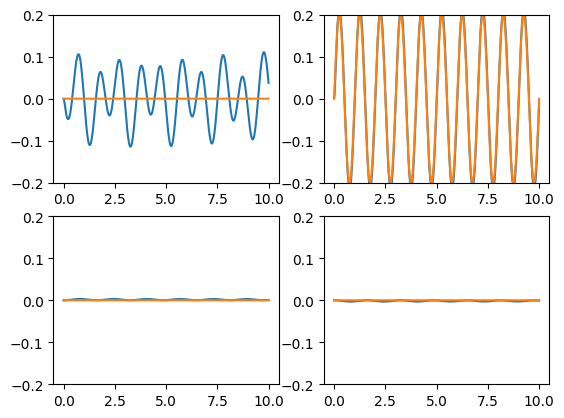

In [71]:
for joint in range(robot.model.nv):
    plt.subplot(2,2,joint+1)
    plt.plot(t,log_q[joint,:])
    plt.plot(t,log_q_des[joint,:])
    plt.ylim((-0.2,0.2))
